In [1]:
from high_throughput_sequencing import *

from matplotlib import pyplot
from networkx   import get_edge_attributes, draw_networkx, circular_layout
from pandas     import DataFrame

# High throughput sequencing

This notebook focuses on the implementation of the algorithmical concepts from the lecture held by Prof. Dr. Manuela Marz at the Friedrich-Schiller-University Jena.

## 1 Genome Assembly

### 1.1. The shortest superstring problem

This problem is strongly related to the task of reconstruction of genomes from short sequence reads.

Given a set of strings $S = \{s_1,...,s_n\}$ we want to find the shortest string $s$, that contains all $s_i$ as substrings.
This Problem is NP-hard.

### 1.2. Solving the shortest superstring problem using hamilton paths

We will define a directed Graph with weighted edges.

$G =  (S, E,\mu)$<br>
$E = S^2$ (all ordered pairs of substrings)<br>
$\mu: E \rightarrow \mathbb{N}$ the maximum amount of overlap possible with this ordered pair of strings. 

Example: $\mu('101','110')=1$

The idea is to identify hamilton-paths (paths  that include every node exactly once) with a maximum weight wich corresponds to a maximum overlap and therefore a shortest superstring.

We will use an implicit representation of the graph (a score matrix) for the computation.<br>
However, there also is an explicit representation of the graph available for visualization.

The best hamilton path and therefore the construction of the shortest superstring is done by brute-forcing<br>
(Every permutation of $0,1,...,|S|$ could represents a path in the graph if the numbers do refer. For all of them we will calculate the score and store only the best off them.)<br>
Of course there are graph algorithms with much higher efficiency, I was just lazy.

Maximum overlap matrix


,0,1,2,3,4,5,6,7
0,0,2,2,1,1,1,1,0
1,0,0,0,1,2,1,1,0
2,0,0,0,0,0,2,2,1
3,0,2,2,1,1,1,1,0
4,0,0,0,0,0,2,2,1
5,1,0,0,0,0,0,0,0
6,0,0,0,1,1,1,1,2
7,0,1,1,2,0,0,0,0


Maximum overlap graph


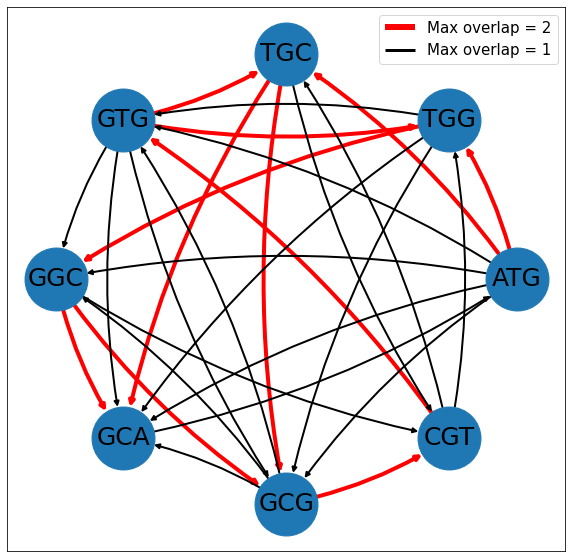

Best score: 14
(0, 1, 4, 6, 7, 3, 2, 5)
(0, 2, 6, 7, 3, 1, 4, 5)
(2 paths)

Found 2 shortest superstrings of length 10
ATGGCGTGCA
ATGCGTGGCA


In [2]:
### INPUT STRINGS ###
S = ['ATG', 'TGG', 'TGC', 'GTG', 'GGC', 'GCA', 'GCG', 'CGT']
### INPUT STRINGS ###

# 1. Computing the graph
matrix = maximum_overlap_matrix(S)

print('Maximum overlap matrix')
display(DataFrame(matrix))
print('Maximum overlap graph')
draw_graph_from_matrix(S, matrix, pyplot.subplots(figsize=(10,10))[1])
pyplot.show()

# 2. Computing the optimal score and paths
best_paths, best_score = brute_force_best_hamilton_paths(matrix)

print('Best score: ' + str(best_score))
for path in best_paths:
    print(path)
print(f'({len(best_paths)} paths)\n')

# 3. Construction of the shortest superstrings
strings = [merge_strings_from_list(get_corresponding_strings(path, S)) for path in best_paths]

print(f'Found {len(strings)} shortest superstrings of length {len(strings[0])}')
for string in strings:
    print(string)

### 1.3. Solving the shortest superstring problem using euler paths

Problem with the hamilton approach:<br>
Inefficient, computing the graph for many and long reads takes a lot of computiational effort.

We will define a directed Graph with weighted edges.<br>
- Nodes: K-mers in the strings
- Edges: There is an edge from K-mer $k_1$ to K-mer $k_2$ when there is a string where $k_1$ starts at position $i$ and $k_2$ at position $i+1$.<br>
The edges are weighted by the amount of instances where this occurs.

The next steps is to identify the (optimal) euler paths of the string.

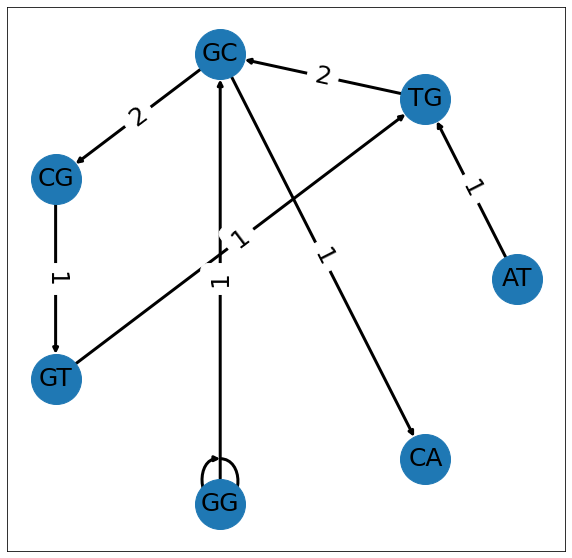

In [3]:
### INPUT STRINGS ###
S = ['ATG', 'TGCG', 'TGC', 'GTG', 'GGGC', 'GCA', 'GCG', 'CGT']
### INPUT STRINGS ###

# 1. Computing the graph
G = k_mer_graph(S, 2)

draw_k_mer_graph(G, pyplot.subplots(figsize=(10,10))[1])

## 2. Read mapping

In transcriptomics or referenceguided genome assembly we need to map hughe amounts of short sequence reads to a genome.<br>
This requires data structures to store genomes in a way that allows us to efficiently search for reads.

### 2.1. Bowtie

In the article: "Ultrafast and memory efficient alignment of short DNA sequences to the human genome" the software Bowtie was presented.
At the time of it's publication the software offered huge improvements in efficiency compared to existing software.
It's more than 22000 citations reflect it's popularity amongst researches and make it one of the classics of bioinformatic.<br>
Also it provides a detailed description of how Bowtie uses **Burrows-Wheeler transformation** of the genome supported by nice figures so it is definitly worth taking a look.<br>
(Link: https://genomebiology.biomedcentral.com/articles/10.1186/Gb-2009-10-3-R25)
 
However, I will try to give a short explaination, too.

First we will generate the Burrows-Wheeler matrix.

In [4]:
### INPUT STRING (case insensitive) ###
genome = 'acaacg'
### INPUT STRING (case insensitive) ###

In [5]:
# 1. Generating all rotations
strings = generate_rotations((genome if genome.endswith('$') else genome+'$').lower())

output = [print(s) for s in strings]

acaacg$
caacg$a
aacg$ac
acg$aca
cg$acaa
g$acaac
$acaacg


In [6]:
# 2. Lexicographical sorting
strings.sort()

output = [print(s) for s in strings]

$acaacg
aacg$ac
acaacg$
acg$aca
caacg$a
cg$acaa
g$acaac


Let's take a closer look at the Burrows-Wheeler matrix (the lexicographically sorted list of rotated strings)!<br>
Because of the way matrix was generated it is quite obvious that:

1. The strings are grouped by their initial letter (because of the lexicographic sorting).
2. In each of the rotated strings, the first letter is the sucessor of the last letter in the original string (because of the rotating).

What is maybe a bit less obvious:

3. This matrix has a property called 'last first (LF) mapping. That is that "the $i$ th occurrence of character X in the last column corresponds to the same text character as the $i$ th occurrence of X in the first column" and both occurrences correspond to the same position in the original String.

How can we determine these $i$ for both the first and last column?<br>
We can simply iterate over the columns and count the occurrences for each character!


In [7]:
from copy import copy

alphabet = {character: -1 for character in ['a', 'c', 'g', 't', '$']}

first_col = ''.join([string[ 0] for string in strings])
last_col  = ''.join([string[-1] for string in strings])

occurence_counts_first_col = count_character_occurence(first_col, alphabet.copy())
occurence_counts_last_col = count_character_occurence(last_col, alphabet.copy())

output = [print(f'{occurence_counts_first_col[i]} {string} {occurence_counts_last_col[i]}') for i, string in enumerate(strings)]

0 $acaacg 0
0 aacg$ac 0
1 acaacg$ 0
2 acg$aca 0
0 caacg$a 1
1 cg$acaa 2
0 g$acaac 1


How does this help us with the exact mapping of reads?

Aligning in Bowtie is an iterative process where we start with aligning the last character of a read.

That means mapping a read $r=r_0, r_1, ..., r_m$ to a genome $g=g_0, g_1, ..., g_n$ requires us to map the read $r'=r_1, ..., r_m$ to the genome first.
So in every step, after we found all $i$ such that $r'=r_1, ..., r_m$ can be aligned to $g_{i+1}, ..., g_{i+m}$ (mapping of $r'$) all that is left to do is checking for every $i$ if $r_0=g_i$ (mapping of r by alignment extension).<br>

Each character of the genome we mapped to in the previous iteration step corresponds to a row in the Burrow-Wheeler matrix corresponds.<br>
For the selected rows we determine those that end with the character that is to be aligned next.<br> 

In [12]:
bowtie = Bowtie('acaacg')
bowtie.map_read('aac')

 0    0 $acaacg 0   
 1    0 aacg$ac 0   
 2    1 acaacg$ 0   
 3    2 acg$aca 0   
 4 -> 0 Caacg$a 1 <-
 5 -> 1 Cg$acaa 2 <-
 6    0 g$acaac 1   

matched previously: c
matches now: a
 0    0 $acaacg 0   
 1    0 aacg$ac 0   
 2 -> 1 ACaacg$ 0 <-
 3 -> 2 ACg$aca 0 <-
 4    0 caacg$a 1   
 5    1 cg$acaa 2   
 6    0 g$acaac 1   

matched previously: a
matches now: a
 0    0 $acaacg 0   
 1 -> 0 AACg$ac 0 <-
 2    1 acaacg$ 0   
 3    2 acg$aca 0   
 4    0 caacg$a 1   
 5    1 cg$acaa 2   
 6    0 g$acaac 1   


This is an time-efficient way to map short reads. However it is not very storage-efficient.<br>

The Burrows-Wheeler matrix has $O(|genome|^2)$ elements. Consider the chromosomal DNA of E.coli which is only $4,600kb$ long, so the Burrows-Wheeler matrix would have $21,160,000,000,000$ elements already.

Now, we will continue with the Burrows-Wheeler transformation.<br>
You should have noticed that only the first and the last column of the matrix are actually needed in the alignment steps.<br>
Thus, all the columns inbetween don't have to be generated in the first place.<br>
Additionally, since the first column is grouped by characters a list with the indices where the groups start or end is  as good as the actual first column but has only $5$ integer numbers (one for each nucleobase and one for the'$').<br>

### 2.2. SEGEMEHL

SEGEMEHL uses Suffix-trees